## Libraries/Settings

In [1]:
import pandas as pd
import time
import random

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import impute
from sklearn import preprocessing
from sklearn import compose

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import median_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import pickle

In [2]:
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', None)

## Acquiring Data

In [3]:
event_urls =  pd.read_csv('data/event_urls.csv')

We have parsed <b>3169</b> event urls

In [4]:
event_urls.head()

,id,url
0,0,https://www.athlinks.com/event/30595/results/Event/854628/Results
1,1,https://www.athlinks.com/event/30595/results/Event/683739/Results
2,2,https://www.athlinks.com/event/30595/results/Event/635676/Results
3,3,https://www.athlinks.com/event/30595/results/Event/536470/Results
4,4,https://www.athlinks.com/event/30595/results/Event/438926/Results


In [5]:
len(event_urls)

3169

In [6]:
# ! awk '(NR == 1) || (FNR > 1)' ./racer_url_files/*.csv > racer_urls.csv

In [7]:
racer_urls = pd.read_csv('data/racer_urls.csv')

In [8]:
racer_urls.sample(5)

,id,event_id,racer_url
71031,47,154,https://www.athlinks.com/event/34885/results/Event/755516/Course/1284424/Bib/5848
144943,62,245,https://www.athlinks.com/event/251739/results/Event/759501/Course/1292280/Bib/1137
286569,41,859,https://www.athlinks.com/event/32292/results/Event/850613/Course/1568645/Bib/1431
79346,78,158,https://www.athlinks.com/event/34885/results/Event/463397/Course/701295/Bib/8852
40476,74,141,https://www.athlinks.com/event/35298/results/Event/687430/Course/1111329/Bib/2480


In [9]:
len(racer_urls)

300004

We have parsed <b>300,004</b> racer urls

In [10]:
url = racer_urls.sample(1).iloc[0]['racer_url']

In [11]:
url

'https://www.athlinks.com/event/35374/results/Event/622463/Course/953986/Bib/2446'

In [12]:
race_data = pd.read_csv('./data/racer_data.csv')

In [13]:
race_data.sample(5)

,id,event_id,racer_url,event_name,distance,weather,course_name,swim_time,t1,bike_time,t2,run_time,full_time,ageGender,location
4602,25,264,https://www.athlinks.com/event/35374/results/Event/525322/Course/784291/Bib/782,Mooloolaba Triathlon,32.0,WEATHER\n83°F28°C,"Olympic Tri (1500M Swim, 40K Bike, 10K Run)\nMIKM",29:52,3:09,1:21:48,1:32,46:50,2:43:12,M 35,"Mooloolaba, AUS"
1343,53,1376,https://www.athlinks.com/event/171810/results/Event/825736/Course/1461097/Bib/435,ETU Standard Distance Triathlon Qualifier (Draft Illegal) St Neots Triathlons Event 3,32.0,WEATHER\nNo data available,"Olympic Triathlon - 1500M Swim, 40K Bike, 10K Run\nMIKM",27:54,3:58,1:23:26,1:03,46:22,2:42:45,F 25,"St Neots, GBR"
8275,11,781,https://www.athlinks.com/event/38790/results/Event/717766/Course/1176609/Bib/414,Byron Bay Triathlon,32.0,WEATHER\nNo data available,"Olympic Tri (1500M Swim, 40K Bike, 10K Run)\nMIKM",27:02,NaN,1:14:56,NaN,47:37,2:29:37,M 45,"Byron Bay, AUS"
8278,14,781,https://www.athlinks.com/event/38790/results/Event/717766/Course/1176609/Bib/371,Byron Bay Triathlon,32.0,WEATHER\nNo data available,"Olympic Tri (1500M Swim, 40K Bike, 10K Run)\nMIKM",25:08,NaN,1:15:33,NaN,49:28,2:30:10,M 40,"Byron Bay, AUS"
4252,18,264,https://www.athlinks.com/event/35374/results/Event/525322/Course/784291/Bib/834,Mooloolaba Triathlon,32.0,WEATHER\n83°F28°C,"Olympic Tri (1500M Swim, 40K Bike, 10K Run)\nMIKM",26:34,2:43,1:09:44,1:46,49:47,2:30:36,M 35,"Mooloolaba, AUS"


## Train/Test Split

First, remove any rows where swim/run/bike time are null (since that's what we're building models to predict). To first convert to seconds, need to standardize column to hh:mm:ss

In [14]:
def standardize_time(x):
    count = str(x).count(':')
    if count == 0:
        return f'00:00:{x}'
    elif count == 1:
        return f'00:{x}'
    return x

In [15]:
race_data['full_time'] = race_data['full_time'].apply(standardize_time)
race_data['swim_time'] = race_data['swim_time'].apply(standardize_time)
race_data['run_time'] = race_data['run_time'].apply(standardize_time)
race_data['bike_time'] = race_data['bike_time'].apply(standardize_time)

In [16]:
race_data['t1'] = race_data['t1'].apply(standardize_time)
race_data['t2'] = race_data['t2'].apply(standardize_time)

In [17]:
race_data['full_time'] = pd.to_timedelta(race_data['full_time'], errors='coerce')
race_data['swim_time'] = pd.to_timedelta(race_data['swim_time'], errors='coerce')
race_data['run_time'] = pd.to_timedelta(race_data['run_time'], errors='coerce')
race_data['bike_time'] = pd.to_timedelta(race_data['bike_time'], errors='coerce')

In [18]:
race_data['t1'] = pd.to_timedelta(race_data['t1'], errors='coerce')
race_data['t2'] = pd.to_timedelta(race_data['t2'], errors='coerce')

Any rows where we don't have a swim/run/bike time, we remove

In [19]:
race_data = race_data.loc[~race_data[['swim_time','run_time','bike_time','full_time']].isnull().any(axis=1)]

In [20]:
race_data['full_time_secs'] = race_data['full_time'].dt.total_seconds()
race_data['swim_time_secs'] = race_data['swim_time'].dt.total_seconds()
race_data['run_time_secs'] = race_data['run_time'].dt.total_seconds()
race_data['bike_time_secs'] = race_data['bike_time'].dt.total_seconds()

In [21]:
race_data['t1_secs'] = race_data['t1'].dt.total_seconds()
race_data['t2_secs'] = race_data['t2'].dt.total_seconds()

Finally, train/test split for model building/evaluation

In [22]:
train, test = train_test_split(race_data, test_size=0.20, random_state=42)

## Inspecting Data

In [23]:
train.columns

Index(['id', 'event_id', 'racer_url', 'event_name', 'distance', 'weather',
       'course_name', 'swim_time', 't1', 'bike_time', 't2', 'run_time',
       'full_time', 'ageGender', 'location', 'full_time_secs',
       'swim_time_secs', 'run_time_secs', 'bike_time_secs', 't1_secs',
       't2_secs'],
      dtype='object')

In [24]:
train.isnull().sum()

id                   0
event_id             0
racer_url            0
event_name          23
distance             2
weather              1
course_name          0
swim_time            0
t1                2415
bike_time            0
t2                2437
run_time             0
full_time            0
ageGender            1
location             1
full_time_secs       0
swim_time_secs       0
run_time_secs        0
bike_time_secs       0
t1_secs           2415
t2_secs           2437
dtype: int64

Observations:
* Need to create null flags and impute on some columns
* Fair number (~25%) where transition times are missing

Too many unavailable data points (>50%) so not worth including

In [25]:
train.weather.value_counts()

WEATHER\nNo data available    4018
WEATHER\n83°F28°C              672
WEATHER\n75°F24°C              424
WEATHER\n88°F31°C              311
WEATHER\n84°F29°C              288
WEATHER\n87°F31°C              250
WEATHER\n81°F27°C              244
WEATHER\n85°F30°C              227
WEATHER\n91°F33°C              217
WEATHER\n67°F19°C              136
WEATHER\n80°F27°C              133
WEATHER\n89°F31°C              122
WEATHER\n104°F40°C             105
WEATHER\n90°F32°C               92
WEATHER\n65°F18°C               86
WEATHER\n60°F15°C               84
WEATHER\n82°F28°C               31
WEATHER                          6
WEATHER\n98°F36°C                4
Name: weather, dtype: int64

## Cleaning Data

Split into separate columns, deal with nulls in general pipeline section

In [26]:
train[['gender','age']] = train.ageGender.str.split(expand=True)
test[['gender','age']] = test.ageGender.str.split(expand=True)

/Users/jacobgoffin/anaconda3/envs/triathlon/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [27]:
train.gender.value_counts()

M    5311
F    2008
U     131
Name: gender, dtype: int64

In [28]:
train[['age','gender']].isnull().sum()

age       1262
gender       1
dtype: int64

In [29]:
train['t1_flag'] = train['t1'].isna().astype('float')
train['t2_flag'] = train['t2'].isna().astype('float')
test['t1_flag'] = test['t1'].isna().astype('float')
test['t2_flag'] = test['t2'].isna().astype('float')

<ipython-input-29-08c640e79d95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['t1_flag'] = train['t1'].isna().astype('float')
<ipython-input-29-08c640e79d95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['t2_flag'] = train['t2'].isna().astype('float')
<ipython-input-29-08c640e79d95>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [30]:
train['age_flag'] = train['age'].isna().astype('float')
test['age_flag'] = test['age'].isna().astype('float')

<ipython-input-30-8c0b6070a8e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['age_flag'] = train['age'].isna().astype('float')
<ipython-input-30-8c0b6070a8e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['age_flag'] = test['age'].isna().astype('float')


In [31]:
train.loc[train.gender.isnull(), 'gender'] = 'U'
test.loc[test.gender.isnull(), 'gender'] = 'U'

/Users/jacobgoffin/anaconda3/envs/triathlon/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [32]:
train.isnull().sum()

id                   0
event_id             0
racer_url            0
event_name          23
distance             2
weather              1
course_name          0
swim_time            0
t1                2415
bike_time            0
t2                2437
run_time             0
full_time            0
ageGender            1
location             1
full_time_secs       0
swim_time_secs       0
run_time_secs        0
bike_time_secs       0
t1_secs           2415
t2_secs           2437
gender               0
age               1262
t1_flag              0
t2_flag              0
age_flag             0
dtype: int64

In [33]:
corrMatrix = train[['full_time_secs','swim_time_secs', 'run_time_secs',
                    'bike_time_secs', 't1_secs','t2_secs','age']].corr()

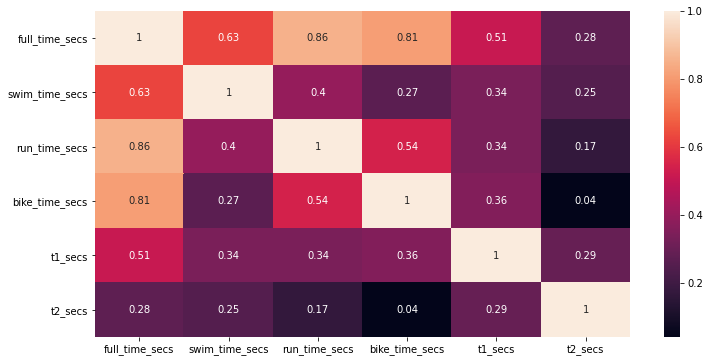

In [34]:
plt.figure(figsize=(12,6))
corrPlot = sn.heatmap(corrMatrix, annot=True)

Notes:
* Run & bike are more correlated with full time than swim (since they take longer). 
* Transition times not very correlated with full time (so don't seem worth keeping, can also be course dependent)


<h3> Looking for outliers </h3>

In [35]:
train[['swim_time','run_time','bike_time','t1','t2']].describe()

,swim_time,run_time,bike_time,t1,t2
count,7451,7451,7451,5036,5014
mean,0 days 00:30:52.025634,0 days 00:53:45.592537,0 days 01:18:03.635485,0 days 00:02:48.347696,0 days 00:01:52.963502
std,0 days 00:07:56.683810,0 days 00:12:21.652996,0 days 00:12:09.483638,0 days 00:01:53.927284,0 days 00:02:13.622439
min,0 days 00:00:14,0 days 00:03:39,0 days 00:00:16,0 days 00:00:03,0 days 00:00:24
25%,0 days 00:26:01,0 days 00:45:36,0 days 01:09:48,0 days 00:01:41,0 days 00:01:10
50%,0 days 00:30:05,0 days 00:51:31,0 days 01:16:12,0 days 00:02:22,0 days 00:01:35
75%,0 days 00:35:06,0 days 00:59:01,0 days 01:24:32,0 days 00:03:22.250000,0 days 00:02:13
max,0 days 01:56:33,0 days 02:21:51,0 days 02:57:29,0 days 00:36:24,0 days 01:24:33


Notes:
* Swim-cutoff: 1 hour
* Bike-cutoff: 3 hours
* Run-cutoff: 2 hours

In [36]:
train_filtered = train.loc[(train.swim_time_secs <= 3600) 
                           & (train.bike_time_secs <= 10800)
                           & (train.swim_time_secs <= 7200)]
test_filtered = test.loc[(test.swim_time_secs <= 3600) 
                           & (test.bike_time_secs <= 10800)
                           & (test.swim_time_secs <= 7200)]

## Pipeline

In [37]:
relevant_columns = ['swim_time_secs','bike_time_secs','run_time_secs','age','gender','age_flag',
                    't1_secs','t2_secs','t1_flag','t2_flag']
train_relevant = train_filtered[relevant_columns]
test_relevant = test_filtered[relevant_columns]

In [38]:
X_train, y_train = train_relevant.drop(columns=['swim_time_secs']), train_relevant['swim_time_secs']
X_test, y_test = test_relevant.drop(columns=['swim_time_secs']), test_relevant['swim_time_secs']

In [39]:
def make_pipeline(regressor=None, scaled=False):
    """
    Create a single pipeline that processes the data and then fits the regressor
    """

    continuous_var = ['bike_time_secs','run_time_secs','age','t1_secs','t2_secs',]
    categorical_var = ['gender',]
    boolean_var = ['age_flag','t1_flag', 't2_flag',]

    if scaled:
        continuous_transformer = Pipeline(steps=[
            ('imputer', impute.SimpleImputer(strategy='median')),
            ('normalize', preprocessing.StandardScaler())
        ])
    else:
        continuous_transformer = Pipeline(steps=[
            ('imputer', impute.SimpleImputer(strategy='median'))
        ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', impute.SimpleImputer(strategy='most_frequent')),
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = compose.ColumnTransformer(
        transformers=[
            ('continuous_var', continuous_transformer, continuous_var),
            ('categorical_var', categorical_transformer, categorical_var),
            ('boolean_var', 'passthrough', boolean_var)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', regressor)])

    return pipeline

## Cross-Validate

Using Median Absolute Error (MAE) as a scoring criteria. Easier to interpret in the context of triathlon race times

In [40]:
lr_model = LinearRegression(fit_intercept=True, normalize=False)
lr_pipeline = make_pipeline(lr_model, scaled=True)

In [41]:
k_fold = KFold(n_splits=5)
cross_val_score(lr_pipeline,
                X_train,
                y_train,
                scoring='neg_median_absolute_error',
                cv=k_fold,)

array([-224.65197853, -225.50492746, -231.8811548 , -216.92079579,
       -229.58566498])

In [42]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_pipeline = make_pipeline(rf_model, scaled=False)

In [43]:
k_fold = KFold(n_splits=5)
cross_val_score(rf_pipeline,
                X_train,
                y_train,
                scoring='neg_median_absolute_error',
                cv=k_fold,)

array([-205.37 , -208.77 , -211.48 , -204.685, -212.395])

Notes:
* Basic RF does improve on a baseline linear regression model
* Achieving around ~3mins 20secs median error for swim time (~10% error)

In [44]:
y_train.median()

1802.5

## Final Model

In [45]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous_var',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['bike_time_secs',
                                                   'run_time_secs', 'age',
                                                   't1_secs', 't2_secs']),
                                                 ('categorical_var',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ge

In [46]:
test_predictions = rf_pipeline.predict(X_test)

In [47]:
median_absolute_error(y_true=y_test, y_pred=test_predictions)

200.88999999999987

In [48]:
rf_pipeline.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous_var',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['bike_time_secs',
                                                   'run_time_secs', 'age',
                                                   't1_secs', 't2_secs']),
                                                 ('categorical_var',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ge

In [56]:
observation = pd.DataFrame({'bike_time_secs': 7200, 'run_time_secs': 2700, 'age': 28, 'gender': 'U',
                            'age_flag': 1, 't1_secs': 0, 't2_secs': 0, 't1_flag': 1, 't2_flag': 1}
                          , index=[0])

In [50]:
pickle.dump(rf_pipeline, open('rf_pipeline.pkl', 'wb'))

In [51]:
loaded_rf_pipeline = pickle.load(open('rf_pipeline.pkl','rb'))

In [57]:
loaded_rf_pipeline.predict(observation)

array([460.64])

In [53]:
X_test.columns

Index(['bike_time_secs', 'run_time_secs', 'age', 'gender', 'age_flag',
       't1_secs', 't2_secs', 't1_flag', 't2_flag'],
      dtype='object')

In [54]:
observation = pd.DataFrame([[3600, 3000, 34, 'M', 1.0, 60, 60, 0.0, 0.0]],columns=['bike_time_secs', 'run_time_secs', 'age', 'gender', 'age_flag',
       't1_secs', 't2_secs', 't1_flag', 't2_flag'])

In [55]:
loaded_rf_pipeline.predict(observation)

array([1587.59])